# Dự đoán giá chứng khoán trong 7 tuần tiếp theo của TRA
---

## 1. Import thư viện
---

In [1]:
import pandas as pd 

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# vẽ biểu đồ cho ngầu 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# xử lý thời gian 
from datetime import datetime

# keras for LSTM 
# phải cài cái này 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN
from keras.layers.convolutional import Conv1D

#Thu vien đo thời gian
import time

## 2. Download data
---

In [2]:
df = pd.read_csv('Data co phieu (8).csv')
df = df.set_index('Ngay')
df

,Thay doi,Mo cua,Cao nhat,Thap nhat,Dong cua,Trung binh,Dong cua DC,Khoi luong
Ngay,,,,,,,,
16/07/2015,0.00 / 0.00%,83.0,83.0,83.0,83.0,83.00,37.41,170
17/07/2015,0.00 / 0.00%,83.0,83.5,83.0,83.0,83.19,37.41,1.19
20/07/2015,0.00 / 0.00%,83.0,83.0,83.0,83.0,83.00,37.41,0
21/07/2015,83.33333333,82.0,82.0,82.0,82.0,82.00,36.96,5.64
22/07/2015,0.00 / 0.00%,82.0,82.0,82.0,82.0,82.00,36.96,0
...,...,...,...,...,...,...,...,...
14/11/2022,91.74311927,94.9,94.9,91.0,91.0,91.13,89.02,3.6
15/11/2022,0.00 / 0.00%,90.9,91.0,90.0,91.0,90.69,89.02,5.2
16/11/2022,90.90909091,84.7,92.7,84.7,91.9,87.21,89.90,5.1


In [3]:
df.shape

(1840, 8)

## 3. Chia tập dữ liệu để làm việc
---

In [4]:
def splitDataset(df):
    length = df.shape[0]
    train_df = df[:length - 35]
    test_df = df[length - 35:]
    return train_df, test_df

train_df, test_df = splitDataset(df)

train_df.shape, test_df.shape

((1805, 8), (35, 8))

## 4. Tiền xử lý tập train và tạo `preprocess_pipeline`
---

In [5]:
# tạo dataframe chỉ bao gồm cột index và cột Adj Close Price 
def createDataFrame(df):
    return df.filter(['Dong cua DC'])

real_train_df = createDataFrame(train_df)
real_train_df.shape

(1805, 1)

In [6]:
# scale dữ liệu train
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(real_train_df)

def reshapeForModel(scaled_train_data):
    return scaled_train_data.reshape((-1,))

scaled_train_data = reshapeForModel(scaled_train_data)
scaled_train_data.shape

(1805,)

In [7]:
def reshapeForModelMLP(scaled_train_data):
    return scaled_train_data

scaled_train_data = reshapeForModelMLP(scaled_train_data)
scaled_train_data.shape

(1805,)

## Tạo data 

In [8]:
# tạo dữ liệu train_X và train_y cho RNN
def createTrainX_y_RNN(scaled_train_data, time_steps=1050, out_length=35):
    train_X = []
    train_y = []
    for i in range(len(scaled_train_data) - time_steps - out_length + 1):
        end_X = i + time_steps
        end_y = end_X + out_length
        train_X.append(scaled_train_data[i:end_X])
        train_y.append(scaled_train_data[end_X:end_y])

    train_X, train_y = np.array(train_X), np.array(train_y)
    return train_X.reshape((train_X.shape[0], train_X.shape[1], 1)), train_y

train_X, train_y = createTrainX_y_RNN(scaled_train_data)
train_X.shape, train_y.shape

((721, 1050, 1), (721, 35))

In [9]:
# tạo dữ liệu train_X và train_y
def createTrainX_y_MLP(scaled_train_data, time_steps=1050, out_length=35):
    train_X = []
    train_y = []
    for i in range(len(scaled_train_data) - time_steps - out_length + 1):
        end_X = i + time_steps
        end_y = end_X + out_length
        train_X.append(scaled_train_data[i:end_X])
        train_y.append(scaled_train_data[end_X:end_y])

    train_X, train_y = np.array(train_X), np.array(train_y)
    return train_X.reshape((train_X.shape[0], train_X.shape[1])), train_y

train_X, train_y = createTrainX_y_MLP(scaled_train_data)
train_X.shape, train_y.shape

((721, 1050), (721, 35))

## preprocess

In [10]:
preprocess_pipeline = Pipeline([
    ('dropper', FunctionTransformer(createDataFrame)),
    ('scaler', MinMaxScaler()),
    ('reshape', FunctionTransformer(reshapeForModel)),
    ('createTrain', FunctionTransformer(createTrainX_y_RNN)),
])

train_X1, train_y1 = preprocess_pipeline.fit_transform(train_df)
train_X1.shape, train_y.shape

((721, 1050, 1), (721, 35))

In [11]:
preprocess_pipeline2 = Pipeline([
    ('dropper', FunctionTransformer(createDataFrame)),
    ('scaler', MinMaxScaler()),
    ('reshape', FunctionTransformer(reshapeForModelMLP)),
    ('createTrain', FunctionTransformer(createTrainX_y_MLP)),
])

train_X2, train_y2 = preprocess_pipeline2.fit_transform(train_df)
train_X2.shape, train_y2.shape

((721, 1050), (721, 35, 1))

## 5. Tạo model
---

In [12]:
# Tạo RNN model 
def createModelRNN(train_X, out_length=35):
    model = Sequential()
    model.add(SimpleRNN(100, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], 1)))
    model.add(SimpleRNN(50, activation='relu',return_sequences=False))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

In [13]:
# Tạo MLP model 
def createModelMLP(train_X, out_length=35):
    model = Sequential()
    model.add(Dense(100, activation='relu',))
    model.add(Dense(50, activation='relu',))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

## 6. `fit` model với tập train và predict tập test 
---

In [14]:
# build model RNN
model1 = createModelRNN(train_X1)
model1.summary()

time_start = time.time()

model1.fit(train_X1, train_y1, batch_size=8, epochs=3)

time_end = time.time()

time_train_RNN = time_end - time_start

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1050, 100)         10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dense (Dense)               (None, 35)                1785      
                                                                 
Total params: 19,535
Trainable params: 19,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
91/91 [==============================] - 30s 306ms/step - loss: 0.0387
Epoch 2/3
91/91 [==============================] - 30s 327ms/step - loss: 0.0033
Epoch 3/3
91/91 [==============================] - 29s 319ms/step - loss: 0.0033


In [15]:
# build model MLP
model2 = createModelMLP(train_X2)

time_start = time.time()

model2.fit(train_X2, train_y2, batch_size=1, epochs=1)

time_end = time.time()

time_train_MLP = time_end - time_start

model2.summary()


721/721 [==============================] - 3s 3ms/step - loss: 0.0098
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (1, 100)                  105100    
                                                                 
 dense_2 (Dense)             (1, 50)                   5050      
                                                                 
 dense_3 (Dense)             (1, 35)                   1785      
                                                                 
Total params: 111,935
Trainable params: 111,935
Non-trainable params: 0
_________________________________________________________________


In [16]:
# tạo tập test_inputs RNN
test_inputs = df[len(df) - len(test_df) - 1050 :]
test_X1, test_y1 = preprocess_pipeline.transform(test_inputs)
test_X1.shape, test_y1.shape

((1, 1050, 1), (1, 35))

In [17]:
# tạo tập test_inputs MLP
test_inputs = df[len(df) - len(test_df) - 1050 :]
test_X2, test_y2 = preprocess_pipeline2.transform(test_inputs)
test_X2.shape, test_y2.shape

((1, 1050), (1, 35, 1))

In [18]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu của RNN
time_start = time.time()

pred_test1 = model1.predict(test_X1)

time_end = time.time()

time_test_RNN = time_end - time_start

pred_test1 = scaler.inverse_transform(pred_test1)
pred_test1 = [round(i) for i in pred_test1[0]]
print(pred_test1)

pred_week_RNN = []
sum = 0
for i in range(1,36):
    sum += pred_test1[i-1]
    if i%5 == 0:
        pred_week_RNN.append(sum//5)
        sum = 0
print(pred_week_RNN)


1/1 [==============================] - 1s 582ms/step
[91, 93, 92, 93, 92, 92, 93, 92, 93, 94, 94, 94, 93, 93, 92, 93, 93, 92, 93, 94, 93, 94, 94, 94, 94, 94, 94, 95, 94, 94, 93, 93, 93, 94, 95]
[92, 92, 93, 93, 93, 94, 93]


In [19]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu của MLP
time_start = time.time()

pred_test2 = model2.predict(test_X2)

time_end = time.time()

time_test_MLP = time_end - time_start

pred_test2 = scaler.inverse_transform(pred_test2)
pred_test2 = [round(i,1) for i in pred_test2[0]]
print(pred_test2)

pred_week_MLP = []
sum = 0
for i in range(1,36):
    sum += pred_test2[i-1]
    if i%5 == 0:
        pred_week_MLP.append(sum//5)
        sum = 0
print(pred_week_MLP)

1/1 [==============================] - 0s 110ms/step
[89.1, 90.9, 88.8, 89.5, 90.8, 89.6, 88.9, 89.5, 86.3, 89.7, 91.4, 88.1, 84.2, 89.9, 86.2, 87.4, 88.7, 86.0, 93.0, 88.7, 87.3, 89.3, 81.7, 85.2, 90.8, 85.7, 85.7, 87.6, 84.8, 87.5, 85.7, 86.4, 85.4, 84.3, 92.5]
[89.0, 88.0, 87.0, 88.0, 86.0, 86.0, 86.0]


In [20]:
#Data test
length = df.shape[0]
test = df[length - 35:]['Dong cua DC'].values
print(test)

test_week = []
sum = 0
for i in range(1,36):
    sum += test[i-1]
    if i%5 == 0:
        test_week.append(round(sum/5,1))
        sum = 0
print(test_week)

[93.91 93.91 93.91 96.75 95.87 93.91 93.91 93.72 93.32 92.93 92.93 92.83
 92.83 92.93 93.91 92.93 90.98 92.44 92.44 92.44 90.98 91.86 93.72 92.83
 90.98 94.89 91.95 92.74 90.98 90.   89.02 89.02 89.9  90.   90.  ]
[94.9, 93.6, 93.1, 92.2, 92.1, 92.1, 89.6]


## Biểu đồ giá giữa Test và RNN

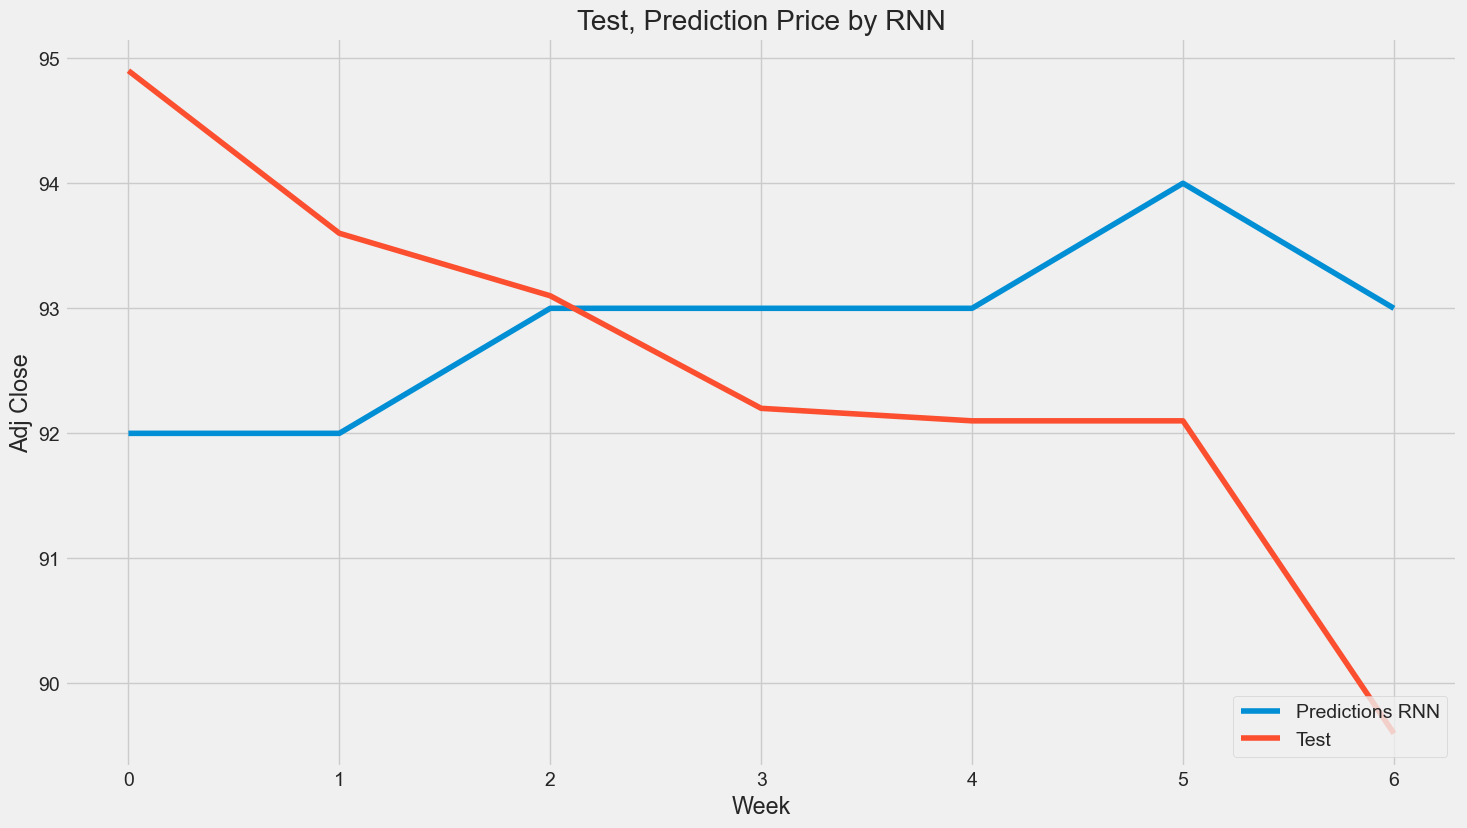

In [21]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by RNN')
plt.xlabel('Week')
plt.ylabel('Adj Close')
plt.plot(pred_week_RNN)

plt.plot(test_week)
plt.legend(['Predictions RNN','Test'], loc='lower right')
plt.show()

## Biểu đồ giá giữa Test và MLP

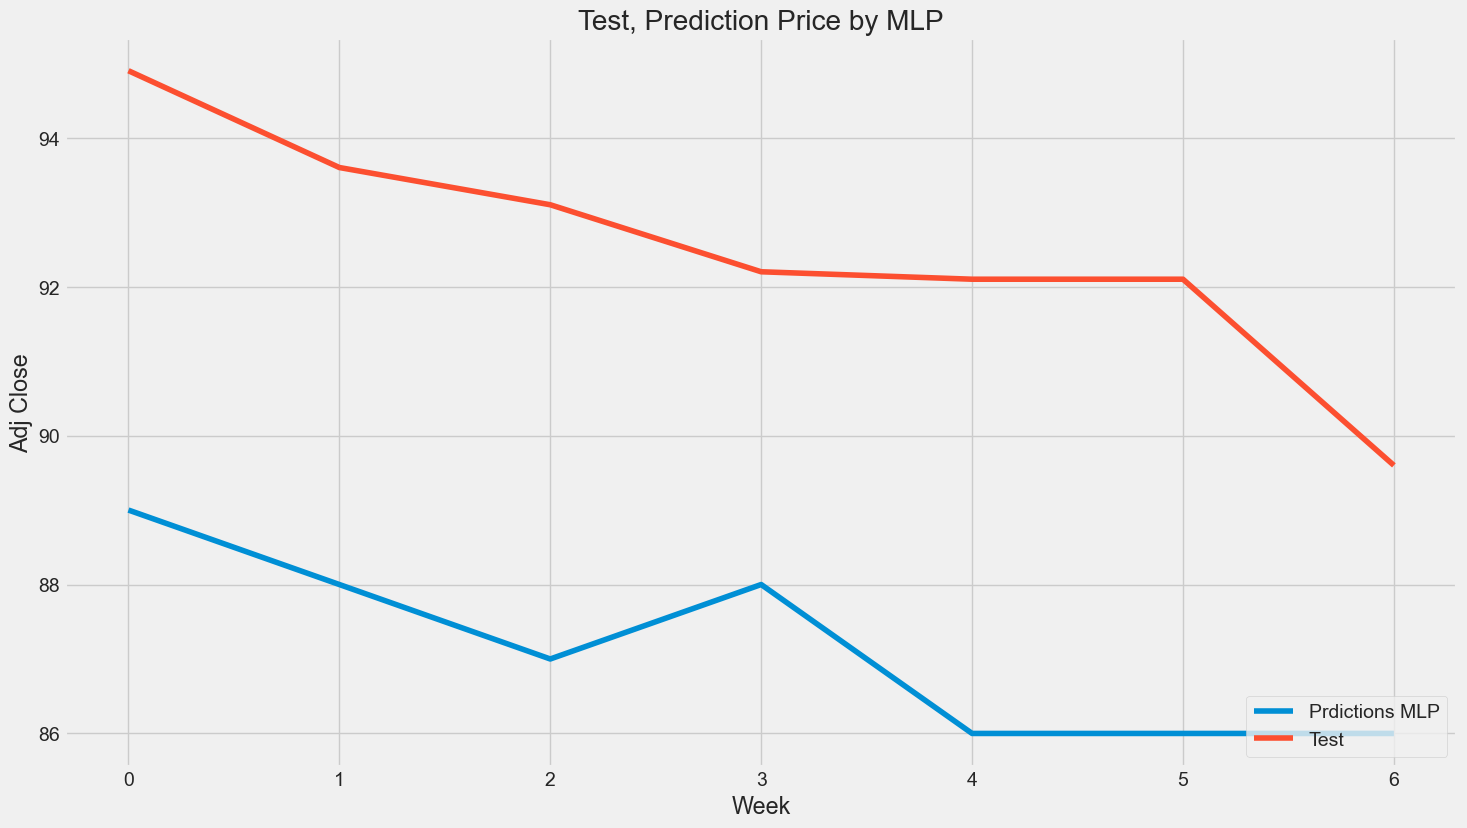

In [22]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by MLP')
plt.xlabel('Week')
plt.ylabel('Adj Close')
plt.plot(pred_week_MLP)

plt.plot(test_week)
plt.legend(['Prdictions MLP','Test'], loc='lower right')
plt.show()

## kNN

In [23]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=10)

time_start = time.time()

neigh.fit(train_X2, train_y1)

time_end = time.time()

time_train_kNN = time_end - time_start


#predict
time_start = time.time()

y_pred = neigh.predict(test_X2)

time_end = time.time()

time_test_kNN = time_end - time_start

In [24]:
pred_test3 = scaler.inverse_transform(y_pred)
print(pred_test3)

[[85.313 85.343 85.109 84.972 84.904 84.806 84.796 84.874 84.815 84.805
  84.756 84.707 84.746 84.717 84.805 84.815 84.903 84.971 85.265 86.106
  86.996 87.866 88.736 89.606 90.427 91.248 92.05  92.853 93.508 93.557
  93.586 93.939 94.292 94.645 94.655]]


In [25]:
# predicted_stock_price_kNN

pred_week_kNN = []
sum = 0
for i in range(1,36):
    sum += pred_test3[0][i-1]
    if i%5 == 0:
        pred_week_kNN.append(round(sum/5,1))
        sum = 0
print(pred_week_kNN)

[85.1, 84.8, 84.7, 85.2, 88.7, 92.6, 94.2]


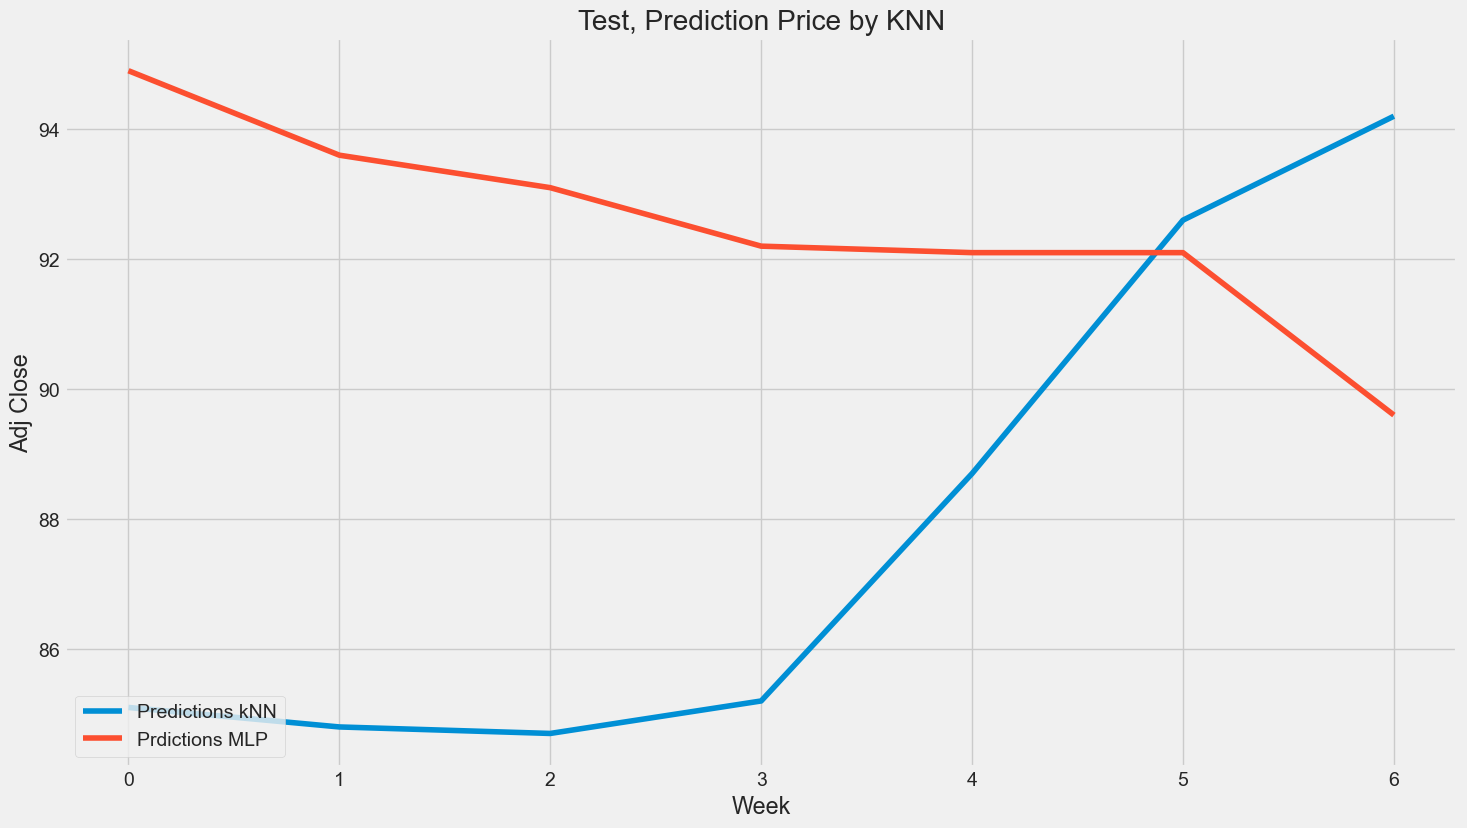

In [26]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by KNN')
plt.xlabel('Week')
plt.ylabel('Adj Close')
plt.plot(pred_week_kNN)

plt.plot(test_week)
plt.legend(['Predictions kNN','Prdictions MLP','Test'], loc='lower left')
plt.show()

## Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression
time_start = time.time()

reg = LinearRegression().fit(train_X2, train_y1)

time_end = time.time()

time_train_LN = time_end - time_start

#Predict
time_start = time.time()

y_pred = reg.predict(test_X2)

time_end = time.time()

time_test_LN = time_end - time_start


In [28]:
pred_test4 = scaler.inverse_transform(y_pred)
print(pred_test4)

[[83.7404737  84.46058044 81.24988545 85.28043573 85.15806338 83.81257425
  85.22218569 87.52428171 86.46256191 84.26715041 86.58178978 87.1541407
  82.65745468 85.4507862  87.89300865 89.74746372 87.18988166 85.70978165
  86.73044611 92.40974383 90.82363196 92.25001172 94.07445822 94.49863598
  97.09649006 93.9262648  95.87956531 93.29743107 91.08922433 93.83957179
  94.18359499 98.16304589 96.30219067 97.70538161 95.2351171 ]]


In [29]:
# predicted_stock_price_LR

pred_week_LR = []
sum = 0
for i in range(1,36):
    sum += pred_test4[0][i-1]
    if i%5 == 0:
        pred_week_LR.append(round(sum/5,1))
        sum = 0
print(pred_week_LR)

[84.0, 85.5, 85.9, 88.4, 93.7, 93.6, 96.3]


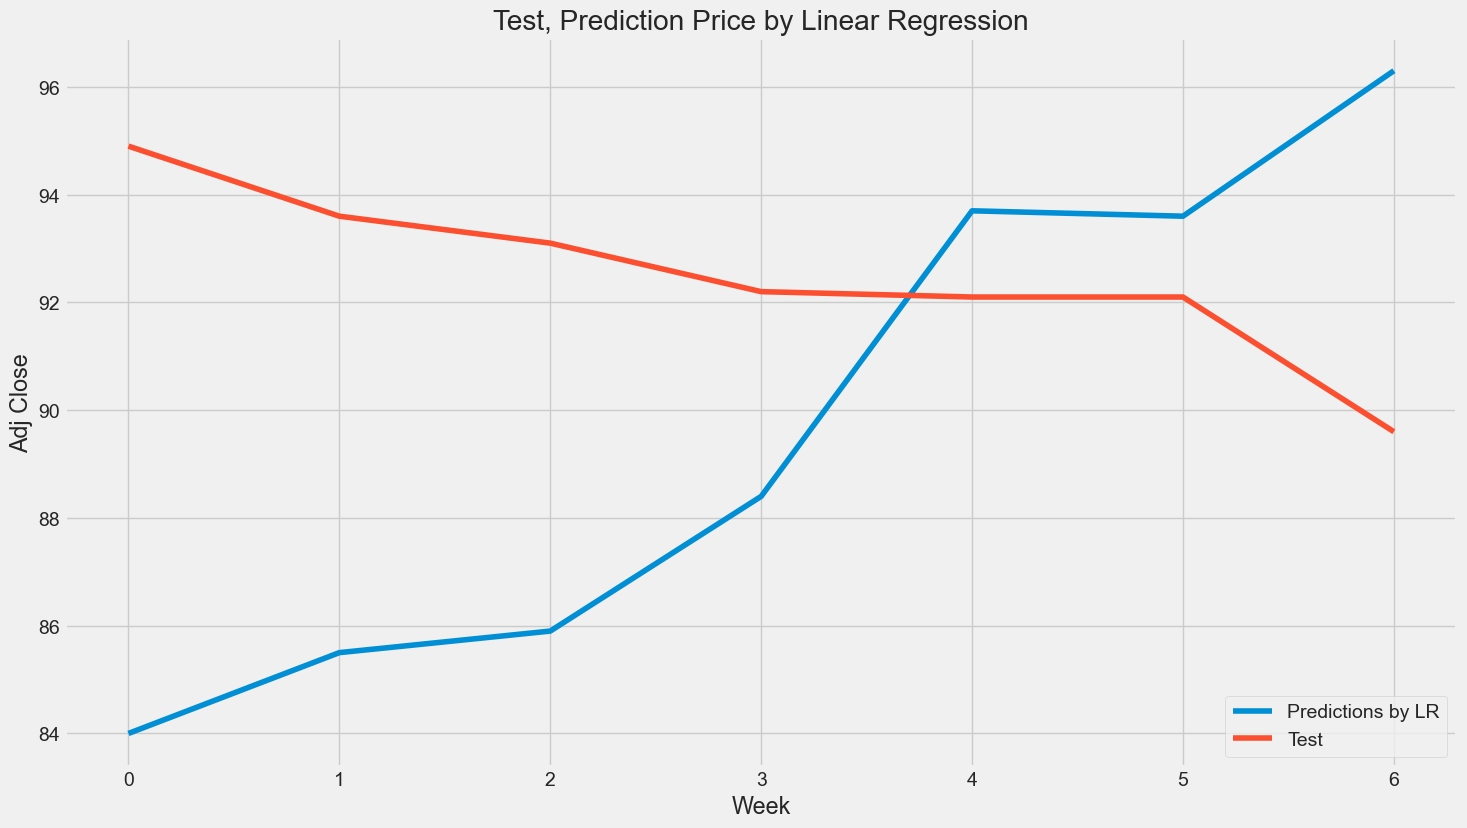

In [30]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by Linear Regression')
plt.xlabel('Week')
plt.ylabel('Adj Close')
plt.plot(pred_week_LR)

plt.plot(test_week)
plt.legend(['Predictions by LR','Test'], loc='lower right')
plt.show()

## Biểu đồ so sánh giá giữa RNN, MLP, kNN và Linear Regression

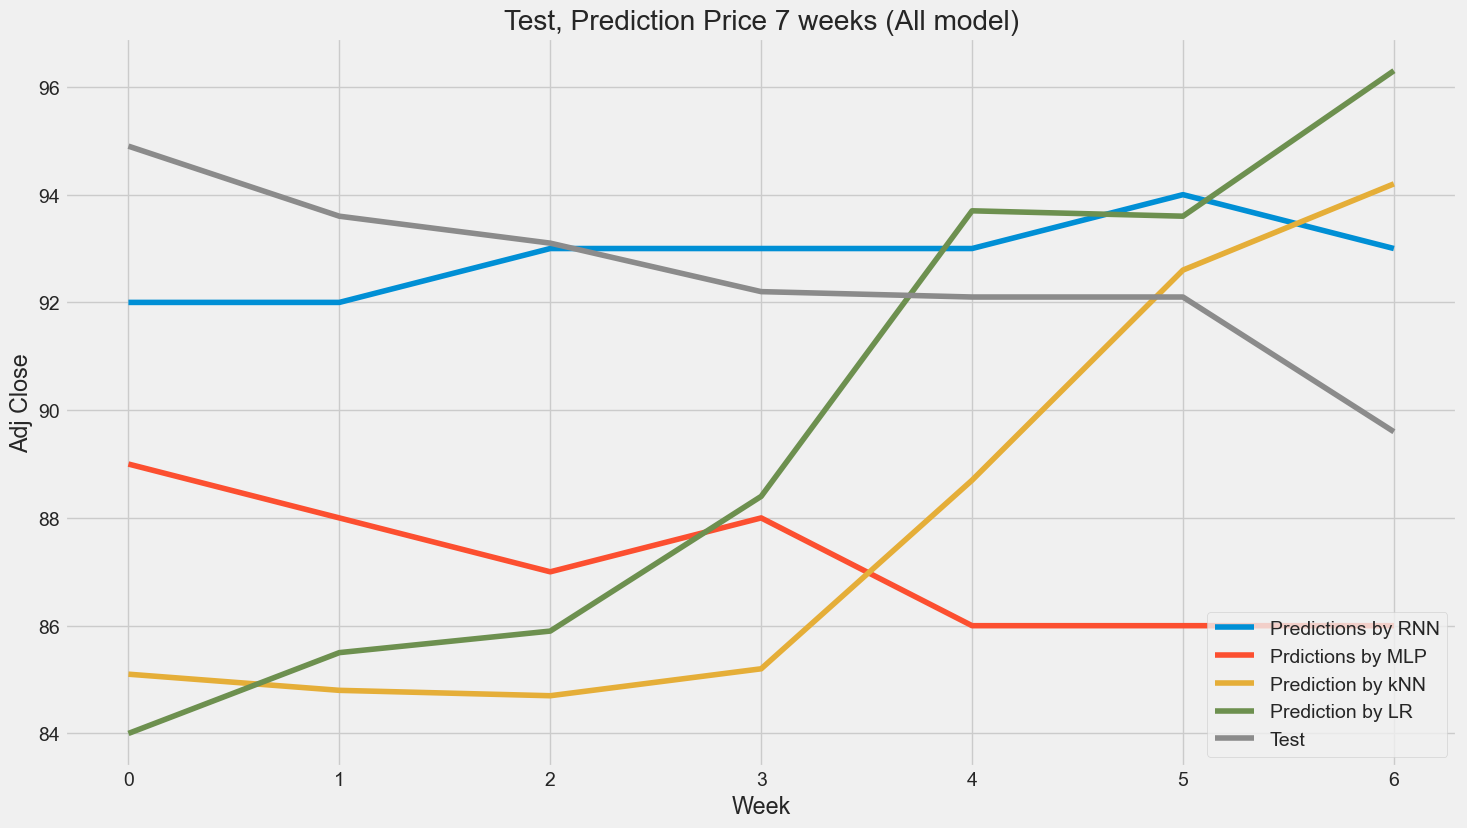

In [31]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price 7 weeks (All model)')
plt.xlabel('Week')
plt.ylabel('Adj Close')
plt.plot(pred_week_RNN)
plt.plot(pred_week_MLP)
plt.plot(pred_week_kNN)
plt.plot(pred_week_LR)


plt.plot(test_week)
plt.legend(['Predictions by RNN','Prdictions by MLP','Prediction by kNN','Prediction by LR','Test'], loc='lower right')
plt.show()

## Thoi gian train

In [32]:
name = ['RNN', 'MLP', 'kNN', 'Linear Regression']

In [33]:
print("Thời gian train các model")
print("RNN: %.5f" %time_train_RNN)
print("MLP: %.5f" %time_train_MLP)
print("kNN: %.5f" %time_train_kNN)
print("LN: %.5f" %time_train_LN)

Thời gian train các model
RNN: 88.64814
MLP: 3.16965
kNN: 0.00100
LN: 0.25713


In [34]:
time_train = [time_train_RNN, time_train_MLP, time_train_kNN, time_train_LN]

<BarContainer object of 4 artists>

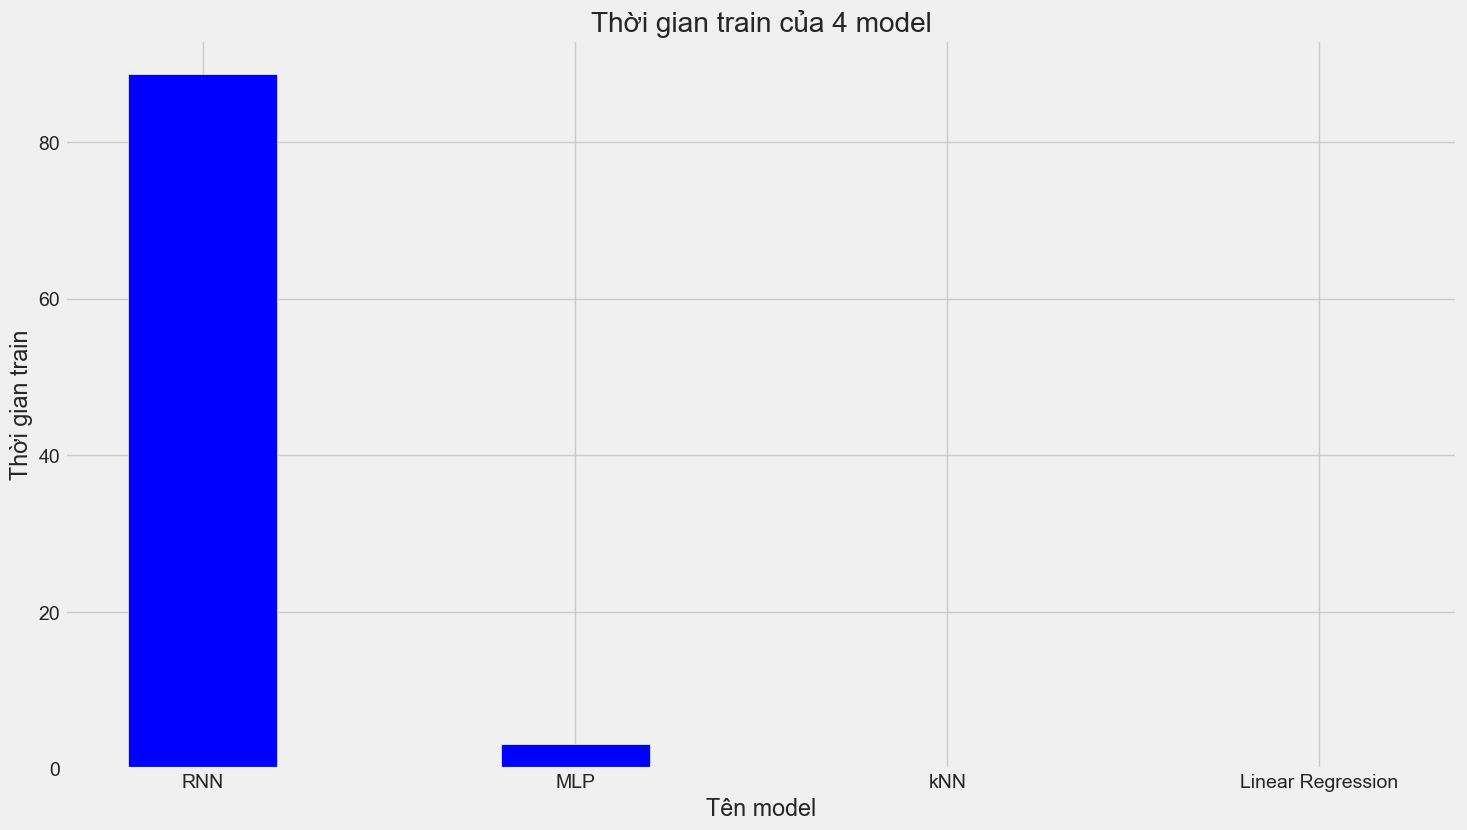

In [35]:
plt.figure(figsize=(16,9))
plt.title('Thời gian train của 4 model')
plt.xlabel('Tên model')
plt.ylabel('Thời gian train')
plt.bar(name, time_train, color ='blue',
        width = 0.4)

## Thoi gian test

In [36]:
print("Thời gian test các model")
print("RNN: %.5f" %time_test_RNN)
print("MLP: %.5f" %time_test_MLP)
print("kNN: %.5f" %time_test_kNN)
print("LN: %.5f" %time_test_LN)

Thời gian test các model
RNN: 0.64750
MLP: 0.19693
kNN: 0.00677
LN: 0.00112


In [37]:
time_test = [time_test_RNN, time_test_MLP, time_test_kNN, time_test_LN]

<BarContainer object of 4 artists>

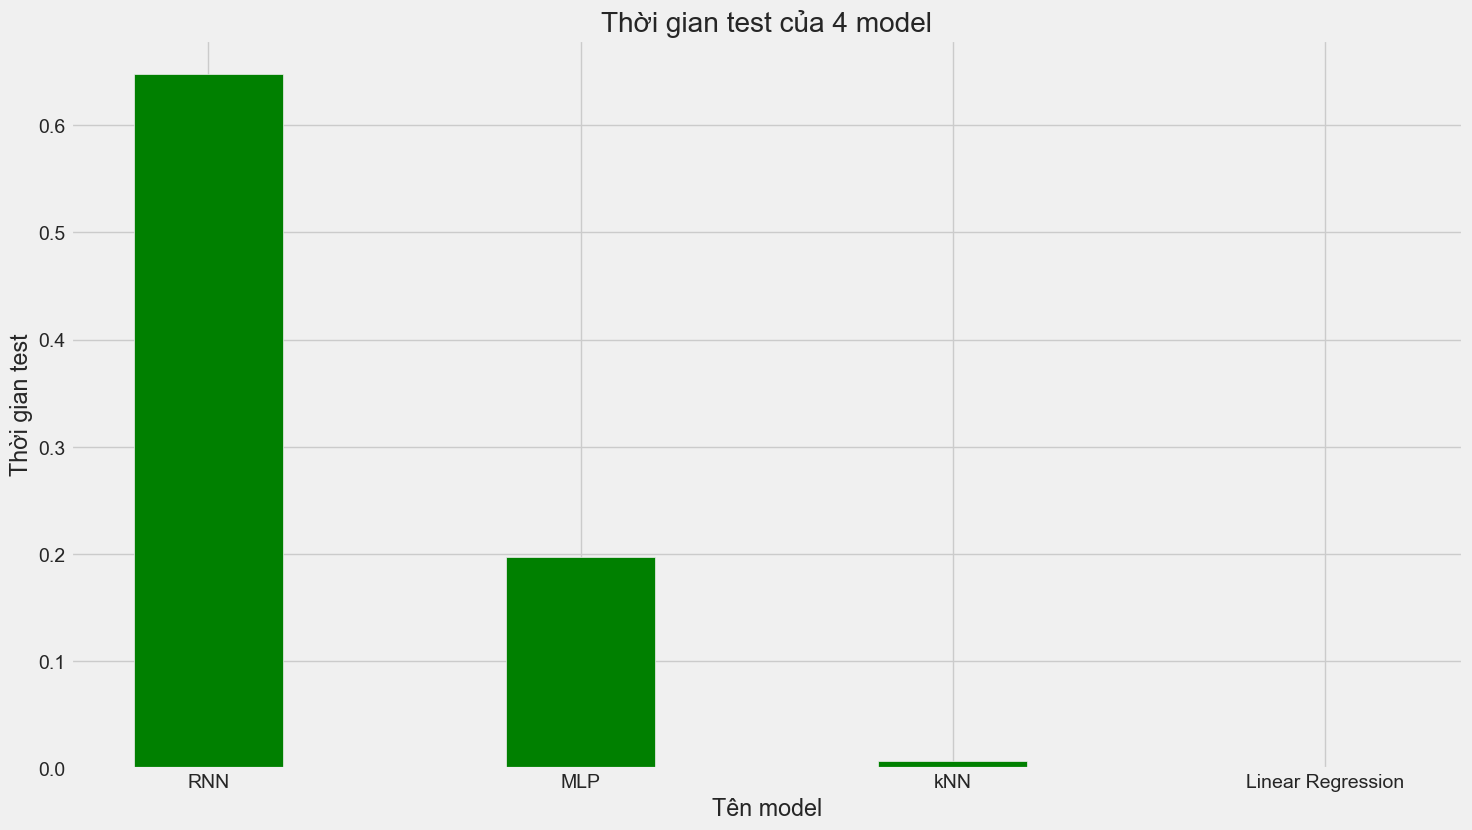

In [38]:
plt.figure(figsize=(16,9))
plt.title('Thời gian test của 4 model')
plt.xlabel('Tên model')
plt.ylabel('Thời gian test')
plt.bar(name, time_test, color ='green',
        width = 0.4)

## MSE

In [39]:
mse_RNN = np.sqrt(np.mean((test - pred_test1) ** 2))
mse_MLP = np.sqrt(np.mean((test - pred_test2) ** 2))
mse_kNN = np.sqrt(np.mean((test - pred_test3[0]) ** 2))
mse_LR = np.sqrt(np.mean((test - pred_test4[0]) ** 2))

# print()
# print(mse_MLP)
# print(mse_kNN)
# print(mse_LR)

In [40]:
print("RNN: %.5f" %mse_RNN)
print("MLP: %.5f" %mse_MLP)
print("kNN: %.5f" %mse_kNN)
print("LR: %.5f" %mse_LR)


RNN: 2.39421
MLP: 5.37515
kNN: 6.91216
LR: 6.79846


In [41]:
mse = [mse_RNN, mse_MLP, mse_kNN, mse_LR]

<BarContainer object of 4 artists>

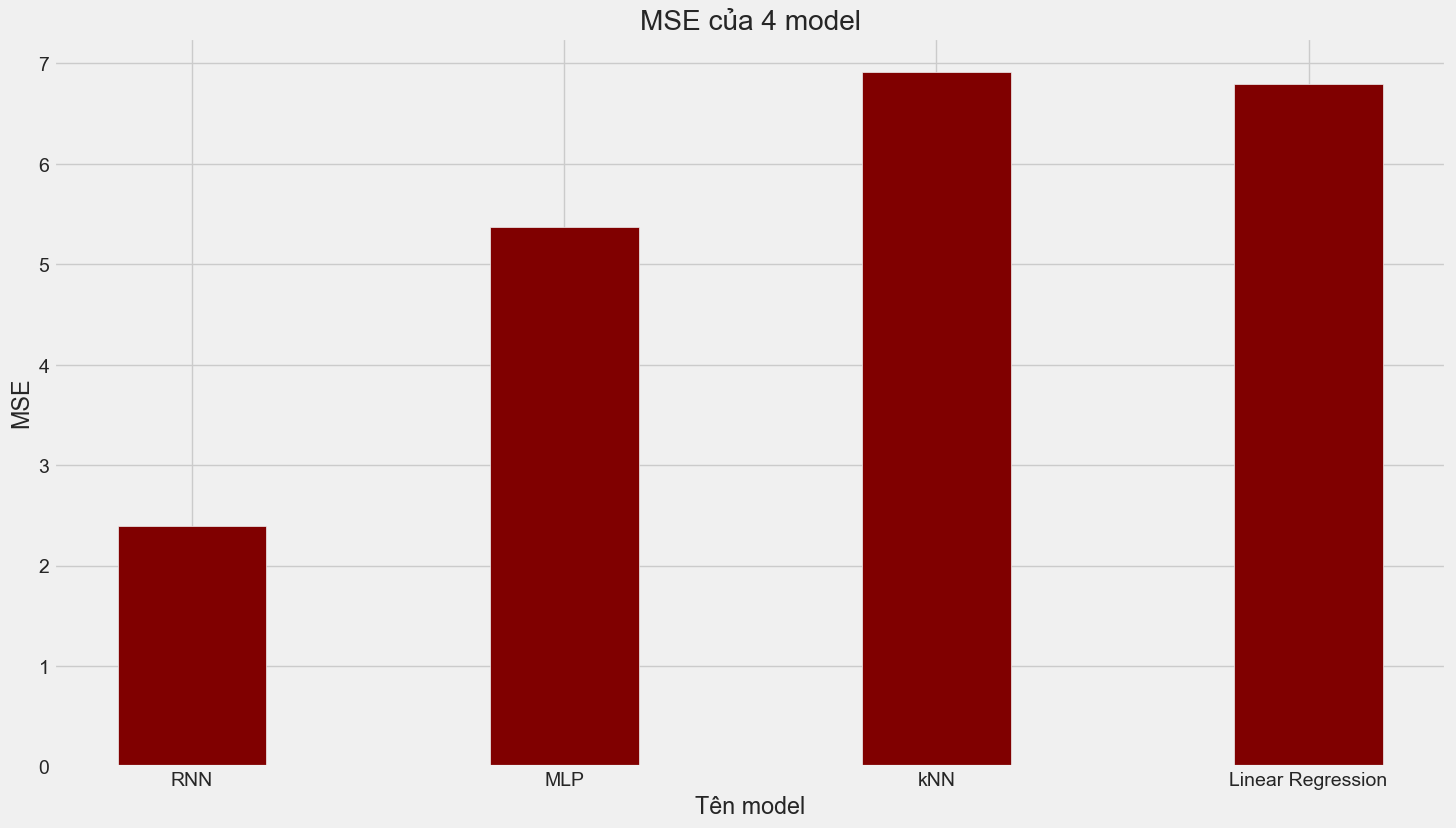

In [42]:
plt.figure(figsize=(16,9))
plt.title('MSE của 4 model')
plt.xlabel('Tên model')
plt.ylabel('MSE')
plt.bar(name, mse, color ='maroon',
        width = 0.4)

## Sử dụng L1 L2 tránh Overfitting

In [43]:
# Tạo RNN model với L1 L2
def createModelRNNwithL1L2(train_X,  out_length=35):
    model = Sequential()
    model.add(SimpleRNN(100, return_sequences=True, input_shape=(train_X.shape[1], 1), recurrent_regularizer='l1_l2'))
    model.add(SimpleRNN(50, return_sequences=False))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

In [44]:
# build model RNN
modelRNNL1L2 = createModelRNNwithL1L2(train_X1)
modelRNNL1L2.summary()
modelRNNL1L2.fit(train_X1, train_y1, batch_size=8, epochs=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 1050, 100)         10200     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dense_4 (Dense)             (None, 35)                1785      
                                                                 
Total params: 19,535
Trainable params: 19,535
Non-trainable params: 0
_________________________________________________________________
91/91 [==============================] - 32s 328ms/step - loss: 5.6729


In [45]:
# tạo tập test_inputs RNN
test_inputs = df[len(df) - len(test_df) - 1050 :]
test_X1, test_y1 = preprocess_pipeline.transform(test_inputs)
test_X1.shape, test_y1.shape

((1, 1050, 1), (1, 35))

In [46]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu của RNN
time_start = time.time()

pred_test1 = modelRNNL1L2.predict(test_X1)

time_end = time.time()

time_test_RNN = time_end - time_start

pred_test1 = scaler.inverse_transform(pred_test1)
pred_test1 = [round(i) for i in pred_test1[0]]
print(pred_test1)

pred_week_RNN_l1l2 = []
sum = 0
for i in range(1,36):
    sum += pred_test1[i-1]
    if i%5 == 0:
        pred_week_RNN_l1l2.append(round(sum/5,1))
        sum = 0
print(pred_week_RNN_l1l2)

1/1 [==============================] - 1s 527ms/step
[95, 92, 95, 93, 89, 93, 88, 90, 94, 95, 94, 94, 90, 84, 91, 90, 90, 99, 98, 99, 100, 94, 98, 96, 94, 93, 92, 96, 96, 99, 89, 91, 99, 90, 92]
[92.8, 92.0, 90.6, 95.2, 96.4, 95.2, 92.2]


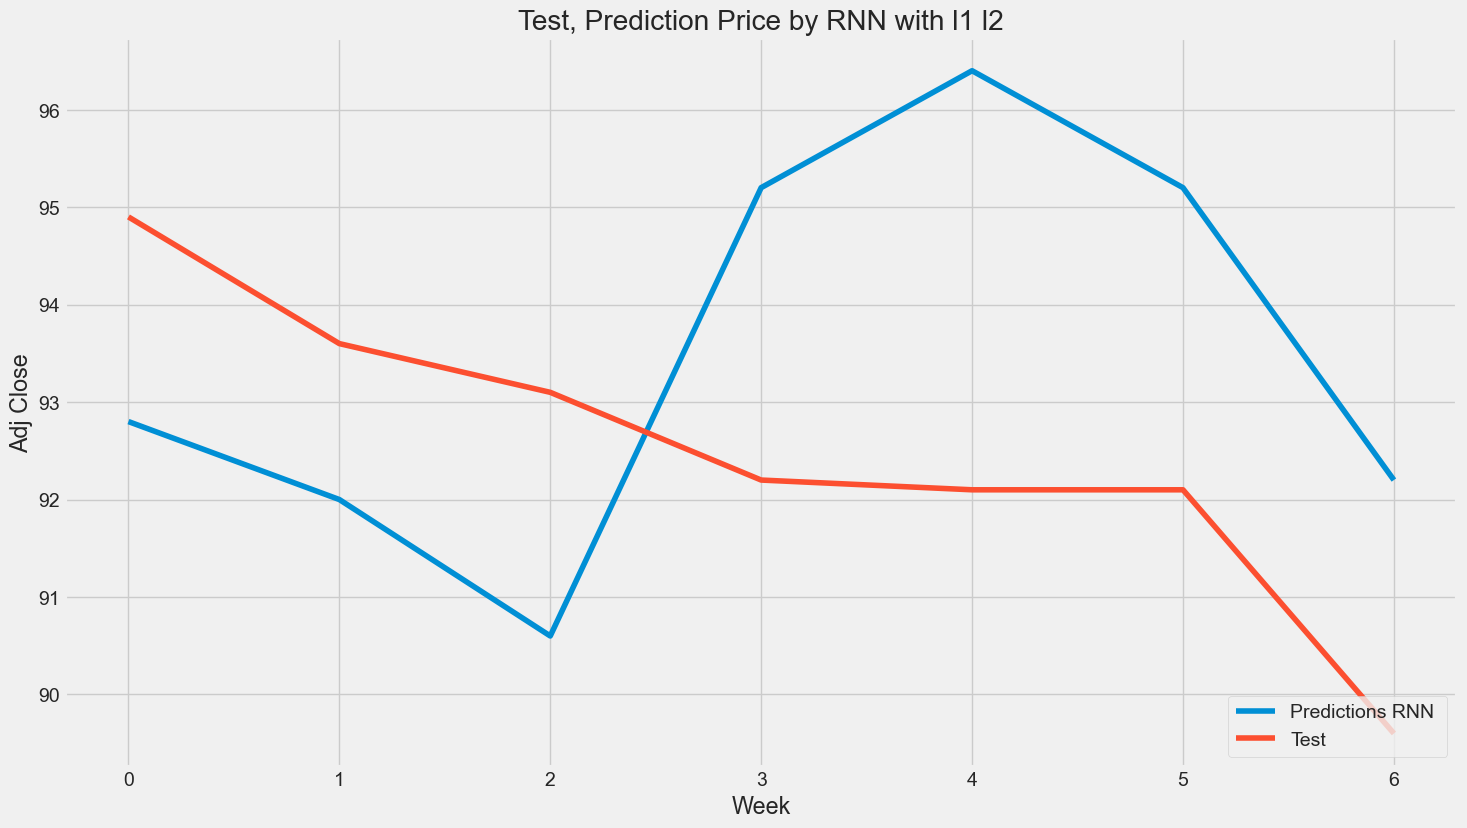

In [47]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by RNN with l1 l2')
plt.xlabel('Week')
plt.ylabel('Adj Close')
plt.plot(pred_week_RNN_l1l2)

plt.plot(test_week)
plt.legend(['Predictions RNN ','Test'], loc='lower right')
plt.show()

## LSTM

In [48]:
# Tạo LSTM model
def createModelLSTM(train_X,  out_length=35):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True,   input_shape=(train_X.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False,))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

In [49]:
# build model LSTM
modelLSTM = createModelLSTM(train_X1)
modelLSTM.summary()
modelLSTM.fit(train_X1, train_y1, batch_size=32, epochs=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1050, 100)         40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense_5 (Dense)             (None, 35)                1785      
                                                                 
Total params: 72,785
Trainable params: 72,785
Non-trainable params: 0
_________________________________________________________________
23/23 [==============================] - 36s 1s/step - loss: 0.0931


In [50]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu của LSTM
time_start = time.time()

pred_test1 = modelLSTM.predict(test_X1)

time_end = time.time()

time_test_RNN = time_end - time_start

pred_test1 = scaler.inverse_transform(pred_test1)
pred_test1 = [round(i) for i in pred_test1[0]]
print(pred_test1)

pred_week_LSTM = []
sum = 0
for i in range(1,36):
    sum += pred_test1[i-1]
    if i%5 == 0:
        pred_week_LSTM.append(round(sum/5,1))
        sum = 0
print(pred_week_LSTM)

1/1 [==============================] - 2s 2s/step
[74, 93, 92, 80, 77, 100, 93, 65, 79, 98, 91, 82, 94, 104, 80, 82, 90, 88, 80, 78, 94, 70, 72, 74, 94, 87, 98, 82, 83, 94, 86, 94, 87, 94, 90]
[83.2, 87.0, 90.2, 83.6, 80.8, 88.8, 90.2]


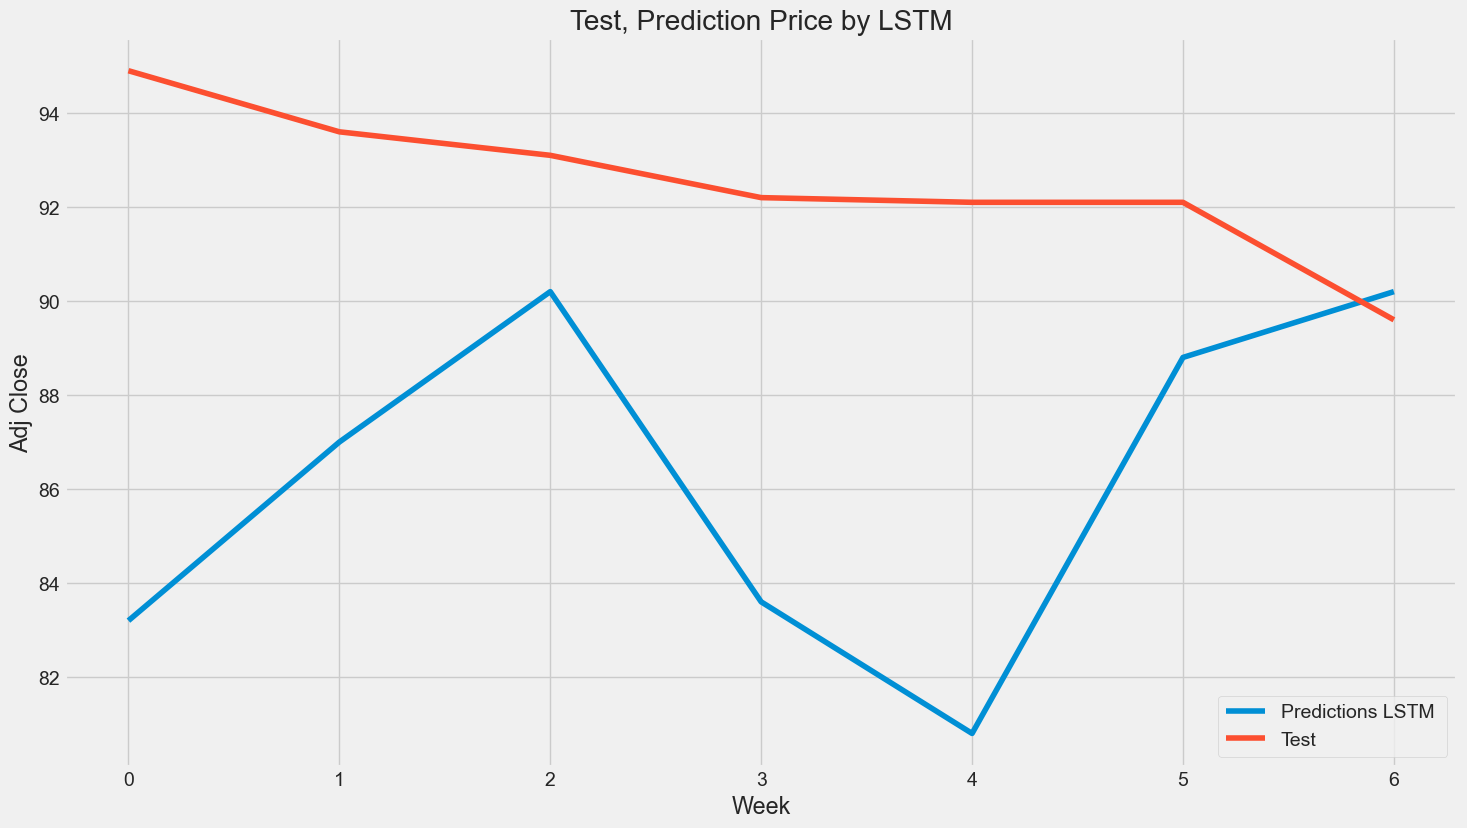

In [51]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by LSTM')
plt.xlabel('Week')
plt.ylabel('Adj Close')
plt.plot(pred_week_LSTM)

plt.plot(test_week)
plt.legend(['Predictions LSTM ','Test'], loc='lower right')
plt.show()

## CNN

In [52]:
# Tạo CNN model
def createModelCNN(train_X, out_length=35):
    model = Sequential()
    model.add(Conv1D(200,kernel_size=32 , input_shape=(train_X.shape[1], 1)))
    model.add(Conv1D(100,kernel_size=32 ))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

In [53]:
# build model CNN
modelCNN = createModelCNN(train_X1)
modelCNN.summary()
modelCNN.fit(train_X1, train_y1, batch_size=1, epochs=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1019, 200)         6600      
                                                                 
 conv1d_1 (Conv1D)           (None, 988, 100)          640100    
                                                                 
 dense_6 (Dense)             (None, 988, 35)           3535      
                                                                 
Total params: 650,235
Trainable params: 650,235
Non-trainable params: 0
_________________________________________________________________
721/721 [==============================] - 33s 44ms/step - loss: 0.0734


In [54]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu của CNN
time_start = time.time()

pred_test1 = modelCNN.predict(test_X1)

time_end = time.time()

time_test_RNN = time_end - time_start

pred_test1 = scaler.inverse_transform(pred_test1[0])
pred_test1 = [round(i) for i in pred_test1[0]]
print(pred_test1)

pred_week_CNN = []
sum = 0
for i in range(1,36):
    sum += pred_test1[i-1]
    if i%5 == 0:
        pred_week_CNN.append(round(sum/5,1))
        sum = 0
print(pred_week_CNN)

1/1 [==============================] - 0s 109ms/step
[77, 74, 74, 75, 73, 74, 73, 72, 71, 75, 70, 74, 75, 75, 74, 74, 72, 74, 69, 73, 72, 77, 71, 74, 72, 77, 74, 75, 76, 74, 79, 76, 73, 73, 74]
[74.6, 73.0, 73.6, 72.4, 73.2, 75.2, 75.0]


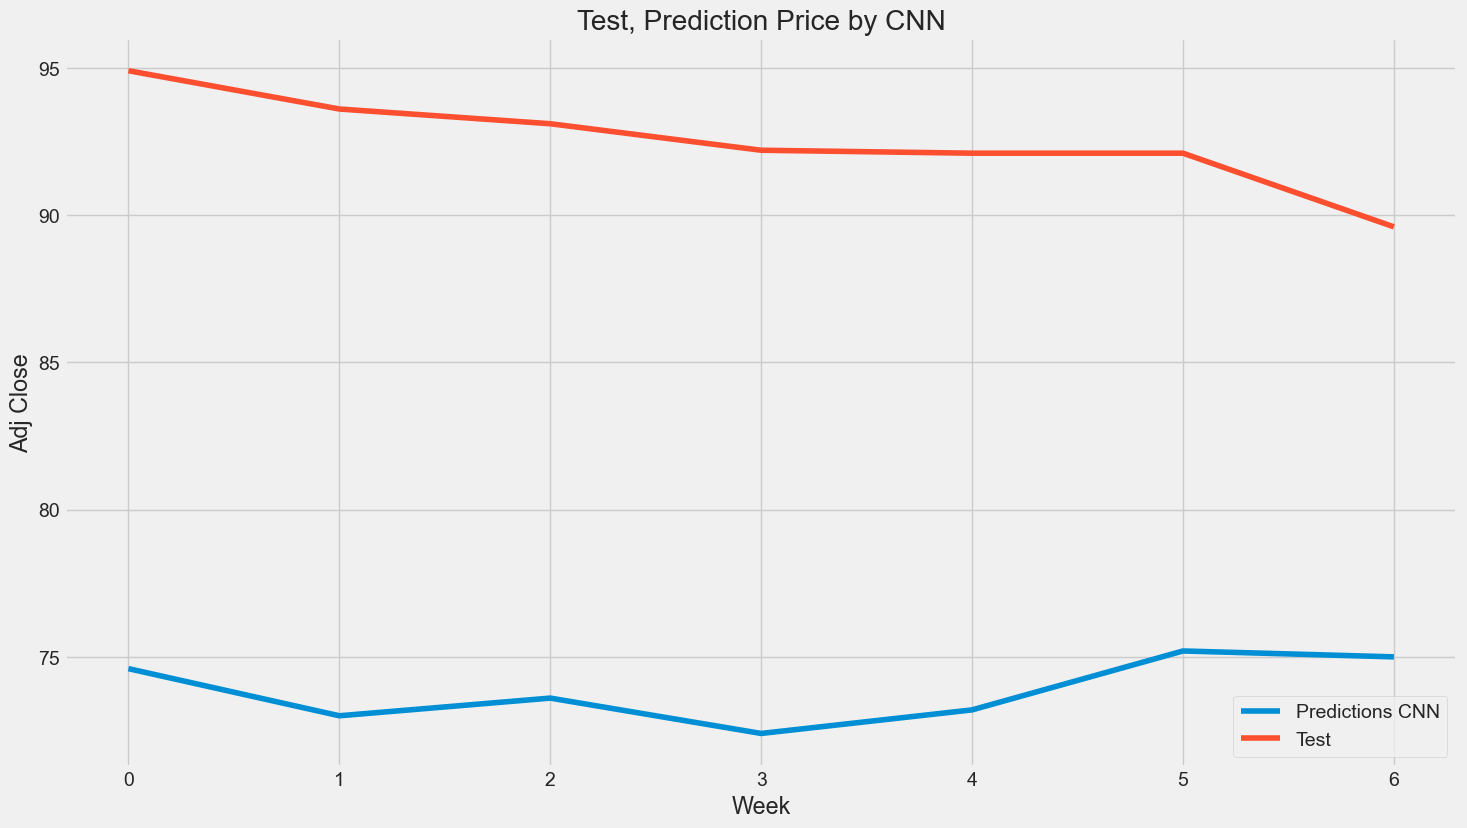

In [56]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by CNN')
plt.xlabel('Week')
plt.ylabel('Adj Close')
plt.plot(pred_week_CNN)

plt.plot(test_week)
plt.legend(['Predictions CNN','Test'], loc='lower right')
plt.show()